# Yale Hackathon

## 1b

Read pickle file and output array

In [23]:
from functions_library import *
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import dynamiqs as dq
import jax.numpy as jnp
from scipy.ndimage import zoom, gaussian_filter, sobel, maximum_filter,label, find_objects, shift

Code is called from a functions library. We want to adjust the values so that the Wigner function can take on both positive and negative values. The data is thus shifted so the W=0 values bisect the average of the max and min values in the array.

Data was centered around midpoint value: 0.3124


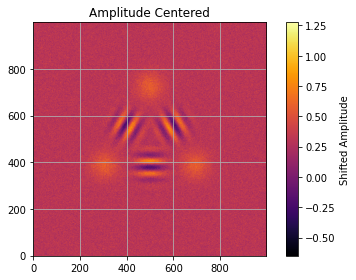

In [2]:
# Load the pickle file and extract the third element
x, y, data = read_pickle("data\\synthetic\\noisy_wigner_8.pickle")

# Target shape: 75 x 75
scale = 1
zoom_factors = (scale, scale)
data_rescaled = zoom(data, zoom_factors)

def center_values_to_midpoint(array):
    """
    Translates the values in the input 2D array so that the new zero level 
    is the midpoint between the global max and min values.

    Parameters:
        array (np.ndarray): 2D input array (e.g., Wigner function or amplitude map)

    Returns:
        shifted_array (np.ndarray): Value-shifted array (centered at 0)
        midpoint (float): The value subtracted (mean of global max and min)
    """
    max_val = np.max(array)
    min_val = np.min(array)
    midpoint = (max_val + min_val) / 2

    shifted_array = array - midpoint
    return shifted_array, midpoint

# Assuming your data is in a variable `A`
A_rescaled, midpoint = center_values_to_midpoint(data_rescaled)

print(f"Data was centered around midpoint value: {midpoint:.4f}")

# Plot it
import matplotlib.pyplot as plt
plt.imshow(data_rescaled, cmap="inferno", origin="lower")
plt.colorbar(label="Shifted Amplitude")
plt.title("Amplitude Centered")
plt.grid(True)
plt.tight_layout()
plt.show()

We want to use an importance sampling algorithm to choose points of interest to sample. Such algorithms include metropolis-hastings, importance sampling, rejection sampling etc. We employ such a scheme here using peak detection and probabilistic sampling from the Wigner function

Detected 33 points of interest.


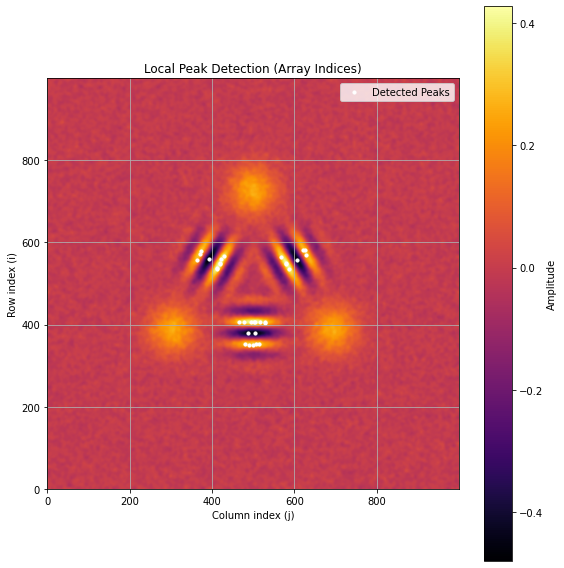

In [8]:
# === STEP 1: Smooth the data to reduce noise (optional) ===
A_rescaled = gaussian_filter(A_rescaled, sigma=2)
A_non_rescaled = gaussian_filter(data_rescaled, sigma=2)

# === STEP 2: Detect local peaks as array indices ===
def find_local_peak_indices(amplitude_map, rel_threshold=0.8, neighborhood_size=5):
    """
    Returns array indices (i, j) where local maxima occur in the 2D amplitude_map.
    Only keeps peaks above rel_threshold * max(amplitude_map).
    """
    local_max = maximum_filter(amplitude_map, size=neighborhood_size)
    peak_mask = (amplitude_map == local_max) & (amplitude_map > rel_threshold * amplitude_map.max())

    labeled, _ = label(peak_mask)
    slices = find_objects(labeled)

    peak_indices = []
    for slc in slices:
        if slc is None:
            continue
        i_slice, j_slice = slc
        i = (i_slice.start + i_slice.stop - 1) // 2
        j = (j_slice.start + j_slice.stop - 1) // 2
        peak_indices.append((i, j))  # array indices

    return np.array(peak_indices, dtype=int)

# === STEP 3: Detect peaks ===
peaks = find_local_peak_indices(A_rescaled, rel_threshold=0.8, neighborhood_size=8)
alphas = find_local_peak_indices(A_non_rescaled, rel_threshold=0.8, neighborhood_size=8)
troughs = find_local_peak_indices(-A_rescaled, rel_threshold=0.8, neighborhood_size=8)

# Combine them into one array
combined_coords = np.vstack((peaks, troughs,alphas))  # shape: (N_total, 2)

print(f"Detected {len(combined_coords)} points of interest.")
# combined_coords is now an (N_peaks, 2) array of (i, j) array indices

# === STEP 4: Plot the result using array index space ===
##############################################################################
plt.figure(figsize=(8, 8))
plt.imshow(A_rescaled, cmap='inferno', origin='lower')
plt.colorbar(label="Amplitude")

if len(combined_coords) > 0:
    i_vals, j_vals = combined_coords[:, 0], combined_coords[:, 1]
    plt.scatter(j_vals, i_vals, s=10, color='white', label='Detected Peaks')  # smaller dots (s=10)

plt.title("Local Peak Detection (Array Indices)")
plt.xlabel("Column index (j)")
plt.ylabel("Row index (i)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Compute probabilities wk

In [12]:
def compute_wk_from_peaks(data_rescaled, peak_coords):
    W_vals = np.array([
        data_rescaled[i, j] for i, j in peak_coords
    ])
    w_ks = 0.5 * (1 + (np.pi / 2) * W_vals)
    return w_ks

wk_list = compute_wk_from_peaks(data_rescaled, combined_coords)

Compute the $E$ matrix for different $\alpha$

In [13]:
def generate_E_alpha_list(wk_list, dim):
    """
    Generate a list of E_alpha_k measurement operators.

    Parameters:
    - wk_list: list of complex displacements (alpha_k)
    - dim: Hilbert space dimension (e.g., 10 or 20)

    Returns:
    - E_wk_list: list of QArrays representing each E_{alpha_k}
    """
    E_wk_list = []
    I = dq.eye(dim)
    P = dq.parity(dim)

    for n in range(len(wk_list)):
        real_part = x[combined_coords[n, 0]].item()
        imag_part = y[combined_coords[n, 1]].item()
        alpha = real_part + 1j * imag_part
        Disp = dq.displace(dim, alpha)
        E_alpha = 0.5 * (I + Disp @ P @ dq.dag(Disp))
        E_wk_list.append(E_alpha)

    return E_wk_list

Use a Hilbert space of $n=150$ then chop it to the size of the wk list 

In [14]:
E_list = generate_E_alpha_list(wk_list, 150)
E_list_chopped = [i[:wk_list.shape[0], :wk_list.shape[0]] for i in E_list]

In [16]:
def reconstruct_density_matrix_cvxpy(E_list, w_list):
    """
    Reconstruct a physical density matrix rho that minimizes
    sum_k |Tr(E_k @ rho) - w_k|^2 using CVXPY.

    Parameters:
    - E_list: list of (dim x dim) Hermitian measurement operators (NumPy or QArrays)
    - w_list: list/array of observed values w_k (real)

    Returns:
    - rho_opt: optimized (dim x dim) density matrix as a NumPy array
    """
    dim = E_list[0].shape[0]
    rho = cp.Variable((dim, dim), complex=True)

    # Physical constraints
    constraints = [
        rho >> 0,                # PSD
        cp.trace(rho) == 1,      # Normalized
        rho == rho.H             # Hermitian
    ]

    # Least squares objective: minimize sum_k |Tr(E_k @ rho) - w_k|^2
    residuals = [cp.trace(E @ rho) - wk for E, wk in zip(E_list, w_list)]
    objective = cp.Minimize(cp.sum_squares(cp.hstack(residuals)))

    # Solve
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=True)

    return rho.value

In [17]:
rho_est = reconstruct_density_matrix_cvxpy(E_list_chopped, wk_list);

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 13 09:20:19 AM: Your problem has 1089 variables, 2179 constraints, and 0 parameters.
(CVXPY) Apr 13 09:20:19 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 13 09:20:19 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 13 09:20:19 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


(CVXPY) Apr 13 09:20:19 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 13 09:20:19 AM: Compiling problem (target solver=SCS).
(CVXPY) Apr 13 09:20:19 AM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 13 09:20:19 AM: Applying reduction Complex2Real
(CVXPY) Apr 13 09:20:19 AM: Applying reduction Dcp2Cone


c:\Users\Russell\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


(CVXPY) Apr 13 09:20:20 AM: Applying reduction CvxAttr2Constr
(CVXPY) Apr 13 09:20:20 AM: Applying reduction ConeMatrixStuffing


c:\Users\Russell\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


(CVXPY) Apr 13 09:20:38 AM: Applying reduction SCS
(CVXPY) Apr 13 09:20:38 AM: Finished problem compilation (took 1.883e+01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Apr 13 09:20:38 AM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 2244, constraints m: 4457
cones: 	  z: primal zero / dual free vars: 2246
	  s: psd vars: 2211, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10,

Choose an $n$ to truncate the Hilbert space further.

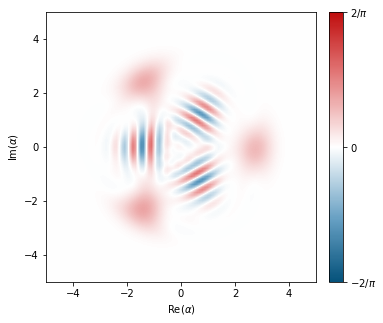

In [21]:
n_truncate = 15
chopped_rho = rho_est[:n_truncate, :n_truncate]/np.trace(rho_est[:n_truncate, :n_truncate])
dq.plot.wigner(dq.todm(chopped_rho))

In [26]:
alpha = 1
psi = dq.unit(dq.coherent(n_truncate, alpha*np.exp(1j*(2/3)*jnp.pi)) + \
        dq.coherent(n_truncate, alpha*np.exp(1j*(4/3)*jnp.pi)) +\
        dq.coherent(n_truncate, alpha*np.exp(1j*(6/3)*jnp.pi)))
dq.fidelity(chopped_rho,dq.todm(dq.fock(chopped_rho.shape[0],0)))

Array(0.00012456, dtype=float32)

In [27]:
chopped_rho

array([[ 1.24555907e-04-1.34197090e-19j, -1.10637176e-04-4.04080868e-04j,
         6.21599333e-04+2.33359832e-03j, -4.64668531e-04-3.15177035e-04j,
         4.50904324e-04-4.04431009e-04j,  7.55517590e-04+5.75898735e-03j,
        -1.14372629e-04+2.35386093e-06j, -1.34423275e-04-1.45702835e-04j,
         5.69300487e-04+7.37620012e-03j, -7.60592310e-05-2.99333286e-04j,
        -3.16973997e-04-1.52553949e-04j,  8.29041968e-05+5.06996633e-03j,
        -9.81934567e-05-2.31134837e-04j,  2.00139633e-04-8.13842050e-05j,
        -1.10077605e-04+1.82462069e-03j],
       [-1.10637176e-04+4.04080868e-04j,  1.40816038e-03-4.39623008e-19j,
        -8.11892211e-03-5.67920809e-05j,  1.43462814e-03-1.22729412e-03j,
         9.11093151e-04+1.82104574e-03j, -1.93429654e-02-2.66372255e-03j,
         9.38583591e-05-3.72910728e-04j,  5.91862169e-04-3.06118363e-04j,
        -2.44228474e-02-4.70404890e-03j,  1.03803500e-03+1.94961890e-05j,
         7.76203374e-04-8.92631687e-04j, -1.65124259e-02-4.23286047e-0